<a href="https://colab.research.google.com/github/takashinnosuke/study_Keras/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#VGG16モデルの畳み込みベースのインスタンス化
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',#このモデルを初期化するための重みのチェックポイント
                  include_top=False,#ネットワークの出力側にある全結合層分類器を含めるかどうか．今回は，catとdogの2つだけに分類するだけで，1000個ものクラスは必要ないのでfalseにしている．
                  input_shape=(150, 150, 3))#ネットワークに供給する画像テンソルの形状．

58900480/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
#学習済みの畳み込みベースを使って特徴量を抽出
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 5.2.2項でsmallデータセットを格納したディレクトリへのパスであることに注意
base_dir = '/content/drive/My Drive/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [18]:
#全結合分類器の定義と訓練
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate = 2e-5),
              loss = 'binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 26ms/step - loss: 0.6360 - acc: 0.6490 - val_loss: 0.4382 - val_acc: 0.8430
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.4276 - acc: 0.8100 - val_loss: 0.3582 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 2s 22ms/step - loss: 0.3487 - acc: 0.8490 - val_loss: 0.3140 - val_acc: 0.8870
Epoch 4/30
100/100 [==============================] - 2s 22ms/step - loss: 0.3205 - acc: 0.8715 - val_loss: 0.2932 - val_acc: 0.8940
Epoch 5/30
100/100 [==============================] - 2s 22ms/step - loss: 0.2807 - acc: 0.8855 - val_loss: 0.2784 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 2s 22ms/step - loss: 0.2598 - acc: 0.8995 - val_loss: 0.2677 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 2s 22ms/step - loss: 0.2498 - acc: 0.9000 - val_loss: 0.2646 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 2s 21ms/step - 

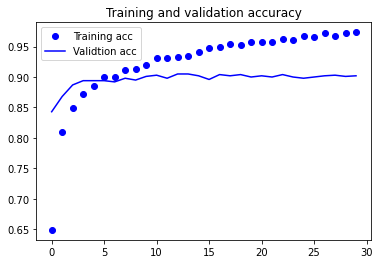

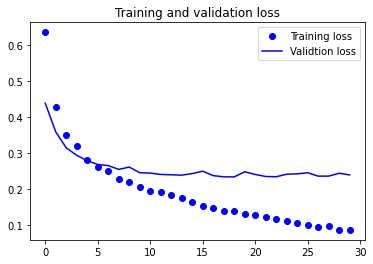

In [19]:
#結果をプロット
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validtion acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validtion loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()